<a href="https://colab.research.google.com/github/Teasotea/textSummarization/blob/main/SentRanking_TextSummarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Implementation of the [TextRank](https://www.analyticsvidhya.com/blog/2018/11/introduction-text-summarization-textrank-python/) Algorithm

# Import Libraries

In [ ]:
!pip install transformers sentencepiece
!pip install sentence_transformers

     |████████████████████████████████| 4.0 MB 5.0 MB/s 
     |████████████████████████████████| 1.2 MB 36.8 MB/s 
     |████████████████████████████████| 77 kB 6.1 MB/s 
     |████████████████████████████████| 6.6 MB 34.3 MB/s 
     |████████████████████████████████| 596 kB 53.1 MB/s 
     |████████████████████████████████| 880 kB 56.5 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=2f33619fc01bc1d66c10f1259e1b611ded037ca5529508e4131e9b970944b4cb
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 79 kB 3.6 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=a779bb7482a08d339694344252fd9e5a699b2

In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import time
from sklearn.metrics.pairwise import cosine_similarity
pd.set_option('display.max_colwidth', None)

In [ ]:
# mount gdrive to save models
from pathlib import Path
from google.colab import drive

drive.mount('/content/gdrive')

GDRIVE = '/content/gdrive/MyDrive/text_summ'
WORKDIR = GDRIVE + '/sent_ranking/'
Path(WORKDIR).mkdir(parents=True, exist_ok=True)

%cd  '/content/gdrive/MyDrive/text_summ/sent_ranking'

Mounted at /content/gdrive
/content/gdrive/MyDrive/text_summ/sent_ranking


# Load Data

In [ ]:
conversation_df = pd.read_csv('https://raw.githubusercontent.com/Teasotea/textSummarization/main/data/session.csv', delimiter = "\t", header=None)
conversation_df = conversation_df.set_axis(['text'], axis=1, inplace=False)
conversation_df.style.set_properties(**{'text-align': 'left'})

,text
0,"Психолог: Добрый день, меня зовут Ирина. Ольга, у нас с вами на сегодня назначена консультация. Надеюсь, что наш разговор будет приятным и полезным. Расскажите с каким запросом вы пришли на нашу первую встречу?"
1,"Ольга: Добрый день, это моя первая консультация в жизни. Я не особо понимаю что именно нужно говорить. Но у меня накопилось достаточно много всего и мне просто хотелось поговорить о том, что сейчас происходит с моей жизнью, ну много чего, конечно, как и у всех, все таки война, переезды, куча всего короче. Просто хотелось чтобы кто-то услышал, помог мне немного разобраться в себе."
2,"Психолог: Ольга, действительно сейчас многие проживают события к которым сложно быть готовым. Давайте начнем понемногу разбираться. Расскажите о себе. Где вы сейчас находитесь, в каких условиях живете, какие события происходят вокруг вас?"
3,"Ольга: Сейчас я чувствую себя относительно в безопасности. Мы переехали из Киева на западную Украину. Здесь можно сказать, что тихо, но я не особо понимаю что происходит. Мне словно приходится начинать все с нуля. Деньги немного есть, ээээ ну там на пару месяцев хватит, но нужно искать работу. Не пойму нужно учится на новую специальность или попытаться найти работу менеджером, как раньше? Хотя кому эти менеджеры нужны, ничего толком не работает, наверно повезло людям которые сохранили работу, прям как-то радостно за них. Потерять финансовую стабильность мне реально тяжело, ждать что что-то наладится, но ничего не наладится же. Ну даже если наладится то не скоро, рада что могла себе обеспечить эту финансовую подушку. Я реально уже думала что можно и начать инвестировать но блин, реально никогда не знаешь, теперь думаю что можно было и пол года назад параллельно с подушкой все делать, но так иногда радует что хоть стабильность в деньгах есть, я все таки смогла научиться управлять немного своими финансами. Ну и новую работу искать, ну и что я тут найду? Наверно скорее всего нужно будет учить английский, вряд ли украинские компании сейчас смогут дать хорошую оплату, надо искать что-то онлайн, стабильное. Хотя какое оно стабильное, надо открывать свое дело в интернете, может делать магазин с доставкой? Да я так и не смогла этот английский выучить сколько уже ходила на курсы. Короче искать работу это мне вообще как настоящее испытание, ну и не думаю что без английского я кому-то нужна. Пока живем в бесплатном жилье, но тоже непонятно надолго это, вообще нужно ли возвращаться, в Киеве хотя бы есть дом, родные стены, ну и удобства все под рукой, но я боюсь ходить по улице вижу везде эти новости про растяжки, бомбы в молоке. Но и помощи от волонтеров больше есть и помощь с едой и вообще дома как то проще, здесь никого не знаю, но и знакомые если честно все уже разъехались и реально жизнь как с нуля. С мужем тоже сложно, постоянно приходится принимать решения, а он как будто оттягивает, но я же тоже не могу все время все делать. Короче мне реально не понятно как вообще быть, я боюсь что-то снова начинать, потому что не понятно на долго или скоро закончится."
4,"Психолог: Давайте выделим вопросы, которые я услышала и продолжим работу. Сейчас у вас нет основной работы для вас большой стресс искать новую, еще вы хотите вернуться в Киев, но не можете решить для себя стоит ли это сейчас делать, также вам хочется получить поддержку от мужа, но вы не можете получить той помощи на которую рассчитываете. Но самым большим испытанием для вас является то, что необходимо начать все с нуля. верно?"
5,"Ольга: Да, но даже не сам факт начала. Понимаете я уже несколько раз все теряла и начинала ""жизнь с этого нуля"". Поэтому мне кажется тут у меня что-то вроде иммунитета. Страх не с самой необходимости, я просто реально понимаю что если я еще раз все потеряю мне может просто не хотеться что-то делать снова. Именно когда живешь в период от нуля до ""опять все хочется"" тут самое страшное. Ощущение, что теряешь время, которого и так постоянно мало, и параллельно же ничего не улучшается, тебе еще наваливается сверху, и

In [ ]:
conversation_df['interlocutor'] = conversation_df.apply(lambda x: 'cli' if x.text.lower().startswith('о') else 'psy', axis=1)
conversation_df['text'] = conversation_df['text'].apply(lambda x: x.strip().split(' ', 1)[1] if x.strip().lower().startswith('психолог') | x.strip().lower().startswith('о') else x.strip())
psy_df = conversation_df[conversation_df['interlocutor'] == 'psy']
cli_df = conversation_df[conversation_df['interlocutor'] == 'cli']
conversation_df.style.set_properties(**{'text-align': 'left'})

,text,interlocutor
0,"Добрый день, меня зовут Ирина. Ольга, у нас с вами на сегодня назначена консультация. Надеюсь, что наш разговор будет приятным и полезным. Расскажите с каким запросом вы пришли на нашу первую встречу?",psy
1,"Добрый день, это моя первая консультация в жизни. Я не особо понимаю что именно нужно говорить. Но у меня накопилось достаточно много всего и мне просто хотелось поговорить о том, что сейчас происходит с моей жизнью, ну много чего, конечно, как и у всех, все таки война, переезды, куча всего короче. Просто хотелось чтобы кто-то услышал, помог мне немного разобраться в себе.",cli
2,"Ольга, действительно сейчас многие проживают события к которым сложно быть готовым. Давайте начнем понемногу разбираться. Расскажите о себе. Где вы сейчас находитесь, в каких условиях живете, какие события происходят вокруг вас?",psy
3,"Сейчас я чувствую себя относительно в безопасности. Мы переехали из Киева на западную Украину. Здесь можно сказать, что тихо, но я не особо понимаю что происходит. Мне словно приходится начинать все с нуля. Деньги немного есть, ээээ ну там на пару месяцев хватит, но нужно искать работу. Не пойму нужно учится на новую специальность или попытаться найти работу менеджером, как раньше? Хотя кому эти менеджеры нужны, ничего толком не работает, наверно повезло людям которые сохранили работу, прям как-то радостно за них. Потерять финансовую стабильность мне реально тяжело, ждать что что-то наладится, но ничего не наладится же. Ну даже если наладится то не скоро, рада что могла себе обеспечить эту финансовую подушку. Я реально уже думала что можно и начать инвестировать но блин, реально никогда не знаешь, теперь думаю что можно было и пол года назад параллельно с подушкой все делать, но так иногда радует что хоть стабильность в деньгах есть, я все таки смогла научиться управлять немного своими финансами. Ну и новую работу искать, ну и что я тут найду? Наверно скорее всего нужно будет учить английский, вряд ли украинские компании сейчас смогут дать хорошую оплату, надо искать что-то онлайн, стабильное. Хотя какое оно стабильное, надо открывать свое дело в интернете, может делать магазин с доставкой? Да я так и не смогла этот английский выучить сколько уже ходила на курсы. Короче искать работу это мне вообще как настоящее испытание, ну и не думаю что без английского я кому-то нужна. Пока живем в бесплатном жилье, но тоже непонятно надолго это, вообще нужно ли возвращаться, в Киеве хотя бы есть дом, родные стены, ну и удобства все под рукой, но я боюсь ходить по улице вижу везде эти новости про растяжки, бомбы в молоке. Но и помощи от волонтеров больше есть и помощь с едой и вообще дома как то проще, здесь никого не знаю, но и знакомые если честно все уже разъехались и реально жизнь как с нуля. С мужем тоже сложно, постоянно приходится принимать решения, а он как будто оттягивает, но я же тоже не могу все время все делать. Короче мне реально не понятно как вообще быть, я боюсь что-то снова начинать, потому что не понятно на долго или скоро закончится.",cli
4,"Давайте выделим вопросы, которые я услышала и продолжим работу. Сейчас у вас нет основной работы для вас большой стресс искать новую, еще вы хотите вернуться в Киев, но не можете решить для себя стоит ли это сейчас делать, также вам хочется получить поддержку от мужа, но вы не можете получить той помощи на которую рассчитываете. Но самым большим испытанием для вас является то, что необходимо начать все с нуля. верно?",psy
5,"Да, но даже не сам факт начала. Понимаете я уже несколько раз все теряла и начинала ""жизнь с этого нуля"". Поэтому мне кажется тут у меня что-то вроде иммунитета. Страх не с самой необходимости, я просто реально понимаю что если я еще раз все потеряю мне может просто не хотеться что-то делать снова. Именно когда живешь в период от нуля до ""опять все хочется"" тут самое страшное. Ощущение, что теряешь время, которого и так постоянно мало, и параллельно же ничего не улучшается, тебе еще наваливается сверху, и нужно разгребать 

In [ ]:
full_cli_text = ' '.join(i for i in cli_df.text.tolist()).strip()
full_psy_text = ' '.join(i for i in psy_df.text.tolist()).strip()
full_text = ' '.join(i for i in conversation_df.text.tolist()).strip()
full_text

'Добрый день, меня зовут Ирина. Ольга, у нас с вами на сегодня назначена консультация. Надеюсь, что наш разговор будет приятным и полезным. Расскажите с каким запросом вы пришли на нашу первую встречу? Добрый день, это моя первая консультация в жизни. Я не особо понимаю что именно нужно говорить. Но у меня накопилось достаточно много всего и мне просто хотелось поговорить о том, что сейчас происходит с моей жизнью, ну много чего, конечно, как и у всех, все таки война, переезды, куча всего короче. Просто хотелось чтобы кто-то услышал, помог мне немного разобраться в себе. Ольга, действительно сейчас многие проживают события к которым сложно быть готовым. Давайте начнем понемногу разбираться. Расскажите о себе. Где вы сейчас находитесь, в каких условиях живете, какие события происходят вокруг вас? Сейчас я чувствую себя относительно в безопасности. Мы переехали из Киева на западную Украину. Здесь можно сказать, что тихо, но я не особо понимаю что происходит. Мне словно приходится начинат

# Text Preprocessing

In [ ]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize, sent_tokenize
import re
nltk.download("stopwords")
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Split Text into Sentences

In [ ]:
def split_text(df):
  sentences = []
  for s in df['text']:
    sentences.append(sent_tokenize(s))
  return [y for x in sentences for y in x] 

In [ ]:
import nltk.data
s_tokenizer = nltk.data.load('tokenizers/punkt/russian.pickle')

In [ ]:
def split_text2(text):
  return [i for i in s_tokenizer.tokenize(text)]

In [ ]:
split_text2(full_text)[:5]

['Добрый день, меня зовут Ирина.',
 'Ольга, у нас с вами на сегодня назначена консультация.',
 'Надеюсь, что наш разговор будет приятным и полезным.',
 'Расскажите с каким запросом вы пришли на нашу первую встречу?',
 'Добрый день, это моя первая консультация в жизни.']

In [ ]:
cli_sent = split_text(cli_df)
psy_sent = split_text(psy_df)
all_sent = split_text(conversation_df)

In [ ]:
all_sent[:5]

['Добрый день, меня зовут Ирина.',
 'Ольга, у нас с вами на сегодня назначена консультация.',
 'Надеюсь, что наш разговор будет приятным и полезным.',
 'Расскажите с каким запросом вы пришли на нашу первую встречу?',
 'Добрый день, это моя первая консультация в жизни.']

### Remove punctuations, numbers and special characters

In [ ]:
# remove punctuations, numbers and special characters
clean_sent = lambda sent: [s.lower() for s in pd.Series(sent).str.replace('[^\w\s]', '')] 

In [ ]:
clean_sentences_psy = clean_sent(psy_sent)
clean_sentences_cli = clean_sent(cli_sent)
clean_sentences_all = clean_sent(all_sent)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [ ]:
clean_sentences_all[:5]

['добрый день меня зовут ирина',
 'ольга у нас с вами на сегодня назначена консультация',
 'надеюсь что наш разговор будет приятным и полезным',
 'расскажите с каким запросом вы пришли на нашу первую встречу',
 'добрый день это моя первая консультация в жизни']

### Stop words removal

In [ ]:
stop_words = set(stopwords.words("russian"))
print(stop_words)

{'того', 'себя', 'тут', 'не', 'моя', 'так', 'она', 'больше', 'себе', 'этого', 'тем', 'эти', 'об', 'со', 'почти', 'вы', 'какая', 'им', 'было', 'ты', 'более', 'он', 'быть', 'после', 'ее', 'нибудь', 'может', 'конечно', 'перед', 'я', 'будто', 'два', 'сам', 'вам', 'они', 'тогда', 'мы', 'другой', 'да', 'нет', 'вдруг', 'чтобы', 'тебя', 'о', 'надо', 'для', 'совсем', 'хорошо', 'тоже', 'потому', 'уже', 'такой', 'ну', 'без', 'по', 'всех', 'если', 'бы', 'разве', 'меня', 'эту', 'от', 'его', 'всю', 'потом', 'во', 'через', 'свою', 'этот', 'там', 'или', 'один', 'три', 'ни', 'кто', 'нас', 'хоть', 'между', 'про', 'же', 'что', 'куда', 'наконец', 'но', 'никогда', 'ней', 'какой', 'еще', 'ей', 'даже', 'нее', 'при', 'всего', 'них', 'над', 'все', 'сейчас', 'когда', 'в', 'него', 'а', 'ли', 'мой', 'как', 'впрочем', 'вот', 'ему', 'теперь', 'где', 'этом', 'на', 'то', 'их', 'раз', 'у', 'ж', 'чуть', 'были', 'зачем', 'лучше', 'только', 'здесь', 'всегда', 'опять', 'был', 'ничего', 'из', 'есть', 'чего', 'вас', 'уж', '

In [ ]:
#add words-parasits
parasite_words = ['реально', 'вообще', 'просто', 'точно','типа','поэтому', 'куча', 'ээээ','особо', 'действительно'
                ,'честно','такое','может', 'пусть', 'постоянно', 'вечно', 'часто', 'блин', 'короче', 'это',
                 'прям', 'хотя', 'такие', 'потому', 'ясно', 'должно', 'нужно','снова', 'пока', 'таки']
new_stopwords_list = stop_words.union(parasite_words)

#remove words that are in NLTK stopwords list
not_stopwords = {"не",'что'} 
final_stop_words = set([word for word in new_stopwords_list if word not in not_stopwords])

print(final_stop_words)

{'того', 'себя', 'тут', 'это', 'моя', 'так', 'она', 'больше', 'пока', 'себе', 'такое', 'этого', 'тем', 'эти', 'об', 'со', 'почти', 'вы', 'какая', 'им', 'было', 'ты', 'пусть', 'более', 'он', 'быть', 'после', 'ее', 'нибудь', 'может', 'конечно', 'перед', 'я', 'будто', 'два', 'сам', 'вам', 'они', 'тогда', 'мы', 'другой', 'да', 'нет', 'вдруг', 'честно', 'снова', 'куча', 'прям', 'чтобы', 'постоянно', 'тебя', 'о', 'надо', 'для', 'совсем', 'хорошо', 'тоже', 'потому', 'уже', 'ээээ', 'короче', 'просто', 'такой', 'ну', 'вечно', 'без', 'по', 'всех', 'если', 'хотя', 'бы', 'разве', 'меня', 'эту', 'от', 'всю', 'его', 'потом', 'во', 'через', 'свою', 'была', 'там', 'или', 'один', 'три', 'ни', 'кто', 'нас', 'хоть', 'между', 'про', 'нужно', 'же', 'блин', 'вообще', 'действительно', 'куда', 'наконец', 'но', 'часто', 'никогда', 'ней', 'какой', 'еще', 'ей', 'даже', 'нее', 'при', 'всего', 'них', 'над', 'все', 'сейчас', 'поэтому', 'когда', 'должно', 'в', 'него', 'а', 'ли', 'мой', 'типа', 'таки', 'особо', 'как'

In [ ]:
# function to remove stopwords
def remove_stopwords(sen):
    sen_new = " ".join([i for i in sen if i not in final_stop_words])
    return sen_new

In [ ]:
# remove stopwords from the sentences
clean_sentences_psy= [remove_stopwords(r.split()) for r in clean_sentences_psy]
clean_sentences_cli = [remove_stopwords(r.split()) for r in clean_sentences_cli]
clean_sentences_all = [remove_stopwords(r.split()) for r in clean_sentences_all]

In [ ]:
clean_sentences_all[:5]

['добрый день зовут ирина',
 'ольга вами сегодня назначена консультация',
 'надеюсь что наш разговор приятным полезным',
 'расскажите каким запросом пришли нашу первую встречу',
 'добрый день первая консультация жизни']

# Further Steps

## Vector Representation of Sentences with SentenceTransformer
[SentenceTransformers](https://www.sbert.net/examples/applications/computing-embeddings/README.html) is a Python framework for state-of-the-art sentence, text and image embeddings.
### Distiluse-base-multilingual-cased

This is a sentence-transformers [model](https://huggingface.co/sentence-transformers/distiluse-base-multilingual-cased): It maps sentences & paragraphs to a 512 dimensional dense vector space and can be used for tasks like clustering or semantic search.

Full Model Architecture:
```
SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: DistilBertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Dense({'in_features': 768, 'out_features': 512, 'bias': True, 'activation_function': 'torch.nn.modules.activation.Tanh'})
)
```



In [ ]:
!pip install -U sentence-transformers

In [ ]:
from sentence_transformers import SentenceTransformer, util, models

In [ ]:
st_model = SentenceTransformer('sentence-transformers/distiluse-base-multilingual-cased')

In [ ]:
sent_vect = lambda sentences: st_model.encode(sentences)

In [ ]:
cli_sentence_vectors = sent_vect(clean_sentences_cli)
psy_sentence_vectors = sent_vect(clean_sentences_psy)
all_sentence_vectors = sent_vect(clean_sentences_all)

In [ ]:
all_sentence_vectors.shape

(101, 512)

In [ ]:
# similarity matrix
def form_sim_matr(sent_vectors):
  sim_mat = np.zeros([len(sent_vectors), len(sent_vectors)])
  for i in range(len(sent_vectors)):
    for j in range(len(sent_vectors)):
      if i != j:
        sim_mat[i][j] = cosine_similarity(sent_vectors[i].reshape(1,sent_vectors.shape[1]), sent_vectors[j].reshape(1,sent_vectors.shape[1]))[0,0]
  return sim_mat

In [ ]:
all_sim_matr = form_sim_matr(all_sentence_vectors)
psy_sim_matr = form_sim_matr(psy_sentence_vectors)
cli_sim_matr = form_sim_matr(cli_sentence_vectors)

## Rank Sentences

In [ ]:
def rank_sentences(text):
  sents = [remove_stopwords(r.split()) for r in clean_sent(split_text2(text))]
  vect = sent_vect(sents)
  sim_mat = form_sim_matr(vect)
  nx_graph = nx.from_numpy_array(sim_mat)
  scores = nx.pagerank(nx_graph)
  ranked_sentences = sorted(((scores[i],s) for i,s in enumerate(split_text2(text))), reverse=True)
  return ranked_sentences

In [ ]:
rank_sent = rank_sentences(full_text)
rank_sent_cli  = rank_sentences(full_cli_text)
rank_sent_psy = rank_sentences(full_psy_text)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [ ]:
rank_sent

[(0.015280488362416264,
  'Такое впечатление что он хочет от меня избавится, типа я что напрягаю его?'),
 (0.014461914070235674,
  'Короче мне реально не понятно как вообще быть, я боюсь что-то снова начинать, потому что не понятно на долго или скоро закончится.'),
 (0.014434574157956202,
  'Может я просто не понимаю что такое жить с партнером.'),
 (0.014132809460087386,
  'меня эти затяжные штуки напрягают это точно, но вот так сказать что я чувствую?'),
 (0.014124363944792877,
  'Я реально хочу в Киев, мне там будет проще собраться с мыслями.'),
 (0.013740701258177945,
  'Блин я уже иногда думаю, а если бы мы не были вместе если мне не надо было бы постоянно ждать, где бы я уже была?'),
 (0.013615646920378876,
  'ну короче, когда я спрашиваю все ли в порядке, он говорит все хорошо, но я не чувствую что все хорошо.'),
 (0.012981252292721924,
  'Потому что в постоянном ожидании чуда жить тоже не легко.'),
 (0.012902347771008764,
  'Понимаете я уже несколько раз все теряла и начинала "ж

In [ ]:
type(rank_sent)

list

In [ ]:
rank_df = pd.DataFrame(rank_sent, columns=['rank', 'sent'])
rank_df_cli  = pd.DataFrame(rank_sent_cli, columns=['rank', 'sent'])
rank_df_psy  = pd.DataFrame(rank_sent_psy, columns=['rank', 'sent'])

In [ ]:
rank_df['clean_sent'] = rank_df['sent'].apply(lambda x : ''.join([remove_stopwords(r.split()) for r in clean_sent(split_text2(x))]))
rank_df_cli['clean_sent'] = rank_df_cli['sent'].apply(lambda x : ''.join([remove_stopwords(r.split()) for r in clean_sent(split_text2(x))]))
rank_df_psy['clean_sent'] = rank_df_psy['sent'].apply(lambda x : ''.join([remove_stopwords(r.split()) for r in clean_sent(split_text2(x))]))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [ ]:
rank_df

,rank,sent,clean_sent
0,0.015280,"Такое впечатление что он хочет от меня избавится, типа я что напрягаю его?",впечатление что хочет избавится что напрягаю
1,0.014462,"Короче мне реально не понятно как вообще быть, я боюсь что-то снова начинать, потому что не понятно на долго или скоро закончится.",не понятно боюсь чтото начинать что не понятно долго скоро закончится
2,0.014435,Может я просто не понимаю что такое жить с партнером.,не понимаю что жить партнером
3,0.014133,"меня эти затяжные штуки напрягают это точно, но вот так сказать что я чувствую?",затяжные штуки напрягают сказать что чувствую
4,0.014124,"Я реально хочу в Киев, мне там будет проще собраться с мыслями.",хочу киев проще собраться мыслями
...,...,...,...
96,0.005604,или останемся тут?,останемся
97,0.005010,Мы переехали из Киева на западную Украину.,переехали киева западную украину
98,0.004979,"Ну и если реально готовится к блекауту, то нужно сделать закупку продуктов на месяц, а если мы вернемся обратно?",готовится блекауту сделать закупку продуктов месяц вернемся обратно
99,0.004448,верно?,верно


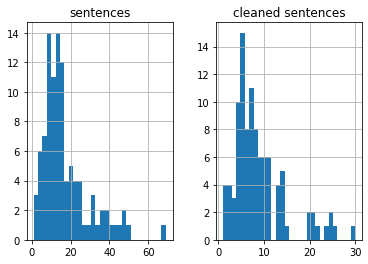

In [ ]:
text_word_count = []
summary_word_count = []

for i in rank_df['sent']:
      text_word_count.append(len(i.split()))

for i in rank_df['clean_sent']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'sentences':text_word_count, 'cleaned sentences':summary_word_count})
length_df.hist(bins = 30)
plt.show()

# Paraphrasing


## GPT3 paraphraser
[The library](https://github.com/RussianNLP/russian_paraphrasers) for Russian paraphrase generation trained on data

### rugpt3large_based_on_gpt2

[Model](https://huggingface.co/sberbank-ai/rugpt3large_based_on_gpt2) was trained with sequence length 1024 using transformers lib by SberDevices team on 80B tokens for 3 epochs. After that model was finetuned 1 epoch with sequence length 2048.

Total training time was around 14 days on 128 GPUs for 1024 context and few days on 16 GPUs for 2048 context.
Final perplexity on test set is 13.6.

In [ ]:
!pip install --upgrade pip
!pip install -r requirements.txt
!pip install russian_paraphrasers

     |████████████████████████████████| 2.1 MB 5.0 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [ ]:
!pip install git+https://github.com/RussianNLP/russian_paraphrasers@master

  Cloning https://github.com/RussianNLP/russian_paraphrasers (to revision master) to /tmp/pip-req-build-h2ubj2cu
  Running command git clone --filter=blob:none --quiet https://github.com/RussianNLP/russian_paraphrasers /tmp/pip-req-build-h2ubj2cu
  Resolved https://github.com/RussianNLP/russian_paraphrasers to commit 8056005656cfa09215d84ed322a3e9f99f401097
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/Maluuba/nlg-eval.git (to revision master) to /tmp/pip-install-46r3028w/nlg-eval_3b3c4dd672394093b3d9bd80c47a8337
  Running command git clone --filter=blob:none --quiet https://github.com/Maluuba/nlg-eval.git /tmp/pip-install-46r3028w/nlg-eval_3b3c4dd672394093b3d9bd80c47a8337
  Resolved https://github.com/Maluuba/nlg-eval.git to commit 7f7993035a2f4729a15d20040fd904933ea58767
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.7/280.7 KB 7.2 MB/s eta

In [ ]:
from russian_paraphrasers import GPTParaphraser

paraphraser = GPTParaphraser(model_name="gpt3", range_cand=False, make_eval=False)

In [ ]:
p = paraphraser.generate(rank_df['sent'][4], n=1, top_k=4, max_length=100, repetition_penalty=1.5)
p

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'origin': 'Может конечно я свои переживания на него перекладываю, но блин в стране которую постоянно раздирают на части ничего хорошего ждать уже не приходится.',
 'results': [{'predictions': ['Я бы с удовольствием ее сменила если б могла хоть часть вины за это переложить.']}]}

In [ ]:
paraphraser.generate(rank_df['clean_sent'][0], n=1, top_k=4, max_length=50, repetition_penalty=1.5)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'origin': 'впечатление что хочет избавится что напрягаю',
 'results': [{'predictions': ['впечатление, будто бы пытается избавиться от чего то тяжелого и напряженного в моей жизни?']}]}

In [ ]:
paraphraser.generate(rank_df['clean_sent'][1], n=5, top_k=10, max_length=35, repetition_penalty=2.5)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'origin': 'что происходит вами не никого ждать',
 'results': [{'predictions': ['что случается с теми кто вас ждёт ответьте на вопрос тест ответы.заранее спасибо..td&gt',
    'происходить с тобой совершенно ни к чему никому из нас правда же ведь так дорогая моя ты в порядке родная всё хорошо однако знаешь почему да милая ну расскажи мне чего тебе хочется на самом деле',
    'с тобой происходить ничего необычного но тебе можно верить потому что это твоя тайна и никому больше ты об этом рассказывать права нетеипически нет да если только он сам этого захочет ведь теб',
    'с тобой происходящее происходить потому что ты никому ничего плохого ни сделала а тебе все верят и говорят при этом чего никогда раньше небыло у тебя так ведь дорогая мой цветочек сладкий моя девочка хороша',
    'ничего с тобой происходить нормально ты в порядке окей так что все будет хорошо понимаешь о чем я говорю а то будешь потом жалеть об упущенной возможности да детка дорогая моя потому как у теб']}]}

*The model performs poorly if max_length < 50, as shown below:*

In [ ]:
paraphraser.generate(rank_df['clean_sent'][1], n=5, top_k=10, max_length=20, repetition_penalty=2.5)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'origin': 'что происходит вами не никого ждать',
 'results': [{'predictions': ['с тобой никто ни кого здесь уж',
    'что с тобой происходить друг мой т',
    'происходить с тобой здесь ни кого уж',
    'ты можешь пойти куда угодно и ожидат',
    'что вы будете делать когда вас никт']}]}

In [ ]:
def extract_res_gpt2_paraphraser(sent, len, samples = 1):
  p = paraphraser.generate(sent, n=samples, top_k=4, max_length=len, repetition_penalty=1.5)
  return p['results'][0]['predictions']

In [ ]:
extract_res_gpt2_paraphraser('я просто знаю что они бывают и мне уже изначально плохо', 50, samples = 2)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


['я только сейчас заметил насколько там всё погано когда их много',
 'я не знал об этом раньше потому как никогда их прежде них']

*Conclusion: As we can see, the model changes a bit the context of sentenses, therefore it can lead to inaccurate summaries*

## RUT5-base-paraphraser
A [paraphraser](https://huggingface.co/cointegrated/rut5-base-paraphraser?text=%D0%B7%D0%BD%D0%B0%D1%8E+%D1%87%D1%82%D0%BE+%D0%B1%D1%8B%D0%B2%D0%B0%D1%8E%D1%82+%D0%B8%D0%B7%D0%BD%D0%B0%D1%87%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE+%D0%BF%D0%BB%D0%BE%D1%85%D0%BE+%D0%B6%D0%B8%D0%B2%D1%83+%D0%B1%D0%BE%D0%BC%D0%B1%D0%BE%D0%B9+%D1%87%D0%B0%D1%81%D0%BE%D0%B2%D1%8B%D0%BC+%D0%BC%D0%B5%D1%85%D0%B0%D0%BD%D0%B8%D0%B7%D0%BC%D0%BE%D0%BC+%D0%BD%D0%B5+%D0%BF%D1%80%D0%B5%D0%B4%D0%BB%D0%B0%D0%B3%D0%B0%D1%8E+%D0%BD%D0%B8%D0%BA%D0%B0%D0%BA%D0%B8%D1%85+%D0%B8%D0%B4%D0%B5%D0%B9+%D0%BD%D0%B5+%D1%85%D0%BE%D1%87%D1%83+%D0%BF%D1%80%D0%BE%D0%B6%D0%B8%D0%B2%D0%B0%D1%82%D1%8C+%D1%81%D0%B8%D0%BB+%D1%8D%D0%BC%D0%BE%D1%86%D0%B8%D0%B8+%D0%BD%D0%B5+%D0%BE%D1%82%D1%81%D0%BB%D0%B5%D0%B6%D0%B8%D0%B2%D0%B0%D1%8E+%D0%BD%D0%B5+%D0%BF%D1%80%D0%B8%D1%8F%D1%82%D0%BD%D0%BE+%D0%BE%D0%BF%D0%B8%D1%81%D0%B0%D1%82%D1%8C+%D0%BD%D0%B5+%D0%BC%D0%BE%D0%B3%D1%83) for Russian sentences described [here](https://habr.com/ru/post/564916/) trained on [Leipzig Corpus](https://wortschatz.uni-leipzig.de/en/download/Russian).

In [ ]:
from transformers import T5ForConditionalGeneration, T5Tokenizer
MODEL_NAME = 'cointegrated/rut5-base-paraphraser'
paraphraser2 = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)
paraphrase_tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)

In [ ]:
def paraphrase_rut5(text, max_size=50, beams=5, grams=4, do_sample=False):
    x = paraphrase_tokenizer(text, return_tensors='pt', padding=True).to(paraphraser2.device)
    out = paraphraser2.generate(**x, encoder_no_repeat_ngram_size=grams, num_beams=beams, max_length=max_size, do_sample=do_sample)
    return paraphrase_tokenizer.decode(out[0], skip_special_tokens=True)

In [ ]:
rank_df['sent'][4]

'Я реально хочу в Киев, мне там будет проще собраться с мыслями.'

In [ ]:
paraphrase_rut5(rank_df['clean_sent'][4])

'Я хочу чтобы вы собрались мыслями'

In [ ]:
paraphrase_rut5(rank_df['sent'][4], max_size=10)

'Я действительно хочу поехать'

In [ ]:
rank_df['clean_sent'][1]

'не понятно боюсь чтото начинать что не понятно долго скоро закончится'

In [ ]:
paraphrase_rut5(rank_df['sent'][1], max_size=20)

'Короче, я реально не понимаю, как быть вообще, боюсь'

In [ ]:
paraphrase_rut5(rank_df['clean_sent'][1], max_size=20)

'Не понимаю что это может произойти'

# Results

In [ ]:
text_p = "Психолог: Добрый день, меня зовут Ирина. Ольга, у нас с вами на сегодня назначена консультация. Надеюсь, что наш разговор будет приятным и полезным. Расскажите с каким запросом вы пришли на нашу первую встречу? Ольга: Добрый день, это моя первая консультация в жизни. Я не особо понимаю что именно нужно говорить. Но у меня накопилось достаточно много всего и мне просто хотелось поговорить о том, что сейчас происходит с моей жизнью, ну много чего, конечно, как и у всех, все таки война, переезды, куча всего короче. Просто хотелось чтобы кто-то услышал, помог мне немного разобраться в себе. Психолог: Ольга, действительно сейчас многие проживают события к которым сложно быть готовым. Давайте начнем понемногу разбираться. Расскажите о себе. Где вы сейчас находитесь, в каких условиях живете, какие события происходят вокруг вас?"

In [ ]:
def parse_dialog(text):
  test_list = text.split(' ')
  size = len(test_list)
  idx_list = [idx for idx, val in
            enumerate(test_list) if val.lower().startswith('ольга:') 
            or val.lower().startswith('о:') or val.lower().startswith('психолог:')]
  res = [test_list[i: j] for i, j in
        zip([0] + idx_list, idx_list + 
        ([size] if idx_list[-1] != size else []))]
  res.remove(res[0])
  for i in res:
    for j in i:
      if j.lower() in ['психолог:', 'о:', 'ольга:']:
        i.remove(j)
  res_list = [item for sublist in res for item in sublist]
  return ' '.join(res_list)


In [ ]:
parse_dialog(input('text: '))

text: Психолог: Добрый день, меня зовут Ирина. Ольга, у нас с вами на сегодня назначена консультация. Надеюсь, что наш разговор будет приятным и полезным. Расскажите с каким запросом вы пришли на нашу первую встречу? Ольга: Добрый день, это моя первая консультация в жизни. Я не особо понимаю что именно нужно говорить. Но у меня накопилось достаточно много всего и мне просто хотелось поговорить о том, что сейчас происходит с моей жизнью, ну много чего, конечно, как и у всех, все таки война, переезды, куча всего короче. Просто хотелось чтобы кто-то услышал, помог мне немного разобраться в себе. Психолог: Ольга, действительно сейчас многие проживают события к которым сложно быть готовым. Давайте начнем понемногу разбираться. Расскажите о себе. Где вы сейчас находитесь, в каких условиях живете, какие события происходят вокруг вас?


'Добрый день, меня зовут Ирина. Ольга, у нас с вами на сегодня назначена консультация. Надеюсь, что наш разговор будет приятным и полезным. Расскажите с каким запросом вы пришли на нашу первую встречу? Добрый день, это моя первая консультация в жизни. Я не особо понимаю что именно нужно говорить. Но у меня накопилось достаточно много всего и мне просто хотелось поговорить о том, что сейчас происходит с моей жизнью, ну много чего, конечно, как и у всех, все таки война, переезды, куча всего короче. Просто хотелось чтобы кто-то услышал, помог мне немного разобраться в себе. Ольга, действительно сейчас многие проживают события к которым сложно быть готовым. Давайте начнем понемногу разбираться. Расскажите о себе. Где вы сейчас находитесь, в каких условиях живете, какие события происходят вокруг вас?'

In [ ]:
def summarize_text(text, remove_stop_words = True, num_bull_points=5, len_of_point=50, is_dialog = False):
  if is_dialog:
    text = parse_dialog(text)
  rank_sent = rank_sentences(text)[:num_bull_points]
  rank_df = pd.DataFrame(rank_sent, columns=['rank', 'sent'])
  if remove_stop_words:
    rank_df['sent'] = rank_df['sent'].apply(lambda x : ''.join([remove_stopwords(r.split()) for r in clean_sent(split_text2(x))]))
  rank_df['summaries'] = rank_df['sent'].apply(lambda x : paraphrase_rut5(x, max_size=len_of_point))
  return rank_df

In [ ]:
summarize_text(full_psy_text)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


,rank,sent,summaries
0,0.060518,скажите раньше возникали ситуации муж оттягивал принятие решений,Если раньше были проблемы с мужем
1,0.058329,давайте начнем разбираться вместе,Давай начнем вместе разбираться
2,0.057134,расскажите подробнее понимаю разные точки зрения какую ситуацию мужем,Скажите мне подробнее о ситуации с мужем
3,0.057099,расскажите представляли вашу жизнь отношений,Расскажите мне о вашей жизни
4,0.054442,давайте начнем понемногу разбираться,Давай начнем разбираться понемногу


In [ ]:
 test1 = summarize_text(full_text, num_bull_points=10, len_of_point=20)
 test1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


,rank,sent,summaries
0,0.015280,впечатление что хочет избавится что напрягаю,Мне кажется что он хочет избавиться от этого
1,0.014462,не понятно боюсь чтото начинать что не понятно долго скоро закончится,Не понимаю что это может произойти
2,0.014435,не понимаю что жить партнером,Не знаю что делать с партнером
3,0.014133,затяжные штуки напрягают сказать что чувствую,Затяжные вещи напрягают что я чувствую
4,0.014124,хочу киев проще собраться мыслями,Я хочу чтобы вы собрались мыслями
5,0.013741,думаю не вместе не ждать,Не думаю что мы будем ждать
6,0.013616,спрашиваю порядке говорит не чувствую что,Не знаю что я хочу сказать
7,0.012981,что постоянном ожидании чуда жить не легко,Что ж жить нелегко постоянно ожидая чуда
8,0.012902,понимаете несколько теряла начинала жизнь нуля,Вы знаете что я потеряла жизнь
9,0.012898,страх не самой необходимости понимаю что потеряю не хотеться чтото делать,Не хочу чтобы я потерял


In [ ]:
def print_n(list_n):
  for i in list_n:
    print(i)
  print()

In [ ]:
print_n(test1.summaries.tolist())

Мне кажется что он хочет избавиться от этого
Не понимаю что это может произойти
Не знаю что делать с партнером
Затяжные вещи напрягают что я чувствую
Я хочу чтобы вы собрались мыслями
Не думаю что мы будем ждать
Не знаю что я хочу сказать
Что ж жить нелегко постоянно ожидая чуда
Вы знаете что я потеряла жизнь
Не хочу чтобы я потерял



In [ ]:
summarize_text(full_cli_text, num_bull_points=3, len_of_point=10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


,rank,sent,summaries
0,0.019326,впечатление что хочет избавится что напрягаю,Мне кажется что он хочет из
1,0.019250,не понятно боюсь чтото начинать что не понятно долго скоро закончится,Не понимаю что это может случиться
2,0.018239,хочу киев проще собраться мыслями,Я хочу чтобы все было


## Visulization

In [ ]:
def show_length_difference(df):
  text_word_count = []
  summary_word_count = []

  for i in df['sent']:
      text_word_count.append(len(i.split()))

  for i in df['summaries']:
      summary_word_count.append(len(i.split()))

  length_df = pd.DataFrame({'sentences':text_word_count, 'summary':summary_word_count})
  length_df.hist(bins = df.shape[0])
  plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


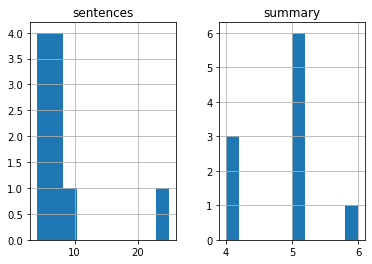

In [ ]:
show_length_difference(summarize_text(full_psy_text, num_bull_points=10, len_of_point=10))

# Evaluation

## Load evaluation dataset

In [ ]:
eval_all = pd.read_csv('https://raw.githubusercontent.com/Teasotea/textSummarization/main/data/evaluation_summary_all.txt', delimiter = "\t", header=None).set_axis(['summaries'], axis=1, inplace=False)
eval_cli = pd.read_csv('https://raw.githubusercontent.com/Teasotea/textSummarization/main/data/evaluation_summary_cli.txt', delimiter = "\t", header=None).set_axis(['summaries'], axis=1, inplace=False)
eval_psy = pd.read_csv('https://raw.githubusercontent.com/Teasotea/textSummarization/main/data/evaluation_summary_psy.txt', delimiter = "\t", header=None).set_axis(['summaries'], axis=1, inplace=False)


In [ ]:
psy_sum = summarize_text(full_psy_text, num_bull_points=9, len_of_point=15)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


## ROUGE: Evaluation​​ [Metric](https://ilmoirfan.com/rouge-an-evaluation-metric-for-text-summarization/)​​ for Text Summarization Task

### ROUGE score (Recall-Oriented Understudy for Gisting Evaluation)

The algorithm to compute ROUGE score considers consecutive tokens a.k.a. n-grams. The n-grams from one text (e.g. the human-written summary) are compared to the n-grams of the other text (e.g. the machine-written summary). **A large overlap of n-grams results in a high ROUGE score** and a low overlap — in a low ROUGE score.

When the aim is abstractive summarization ROUGE is best used **only as an initial indicator** of how much the machine-written summary overlaps with the human written summary, because it does not take into account the semantic meaning and the factual accuracy of the summaries.

Pros and cons of using [ROUGE](https://towardsdatascience.com/to-rouge-or-not-to-rouge-6a5f3552ea45)

In [ ]:
!pip install Rouge

In [ ]:
from rouge import Rouge 
rouge = Rouge()

In [ ]:
serie_to_text = lambda s: '. '.join(s.tolist())

In [ ]:
summary = serie_to_text(psy_sum.summaries)
reference = serie_to_text(eval_psy.summaries)

In [ ]:
summary # summary made by model

'Если раньше были проблемы с мужем. Давай начнем вместе разбираться. Скажите мне подробнее о ситуации с мужем. Расскажите мне о вашей жизни. Давай начнем разбираться понемногу. Вы находитесь в каком состоянии живёте. Расскажите какие чувства вы чувствуете неопределенность. Вы готовы принимать ответственность за принимаемые решения. Расскажите какой запросом пришла наша первая встреча'

In [ ]:
reference # summary made by human

'Цель встречи. Расскажите о себе. Нет основной работы. Желание вернуться в Киев. Нет поддержки от мужа. Страх начать с нуля. Страх неопределенности. Нужно разобратся с емоциями. ДЗ: Записывать в дневник ситуацию и эмоции'

In [ ]:
rouge.get_scores('Цель встречи', 'Цель встречи !')

[{'rouge-1': {'f': 0.7999999952000001, 'p': 1.0, 'r': 0.6666666666666666},
  'rouge-2': {'f': 0.6666666622222223, 'p': 1.0, 'r': 0.5},
  'rouge-l': {'f': 0.7999999952000001, 'p': 1.0, 'r': 0.6666666666666666}}]

In [ ]:
rouge.get_scores(summary, reference)

[{'rouge-1': {'f': 0.11267605150565385,
   'p': 0.09523809523809523,
   'r': 0.13793103448275862},
  'rouge-2': {'f': 0.0, 'p': 0.0, 'r': 0.0},
  'rouge-l': {'f': 0.11267605150565385,
   'p': 0.09523809523809523,
   'r': 0.13793103448275862}}]

In [ ]:
rouge.get_scores(summary, full_psy_text)

[{'rouge-1': {'f': 0.1230769203680474,
   'p': 0.38095238095238093,
   'r': 0.07339449541284404},
  'rouge-2': {'f': 0.017241376890771907,
   'p': 0.061224489795918366,
   'r': 0.010033444816053512},
  'rouge-l': {'f': 0.1230769203680474,
   'p': 0.38095238095238093,
   'r': 0.07339449541284404}}]

# Final words about possible improvements



*   Explore dataset (EDA): do linguistical and statistical analysis, for example word frequency calculation, normalization, consider priority of words in language. Fine research on that topic is in this [article](https://www.ijert.org/research/text-summarizer-using-abstractive-and-extractive-method-IJERTV3IS050821.pdf )
*   Try RNN and LSTM Solution (idea explained [here](https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/ )) and compare the results
*   Improve Text Preprocessing: do plural resolution, abbreviation resolution, synonimum resolution and remove personal information, like: names, cities and so on with the help of NER model
*   Fine-Tune Transformers on custom dataset, which consists of psycological sessions recordings

